# Basic imports
---

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
import json
%matplotlib inline

from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

from datasets import load_dataset

from typing import Callable, Optional, List, Dict

# Download and process the data set
---

In [37]:
# Load CORD-v2 dataset
print("Loading CORD-v2 dataset from Hugging Face...")
ds = load_dataset("naver-clova-ix/cord-v2")

print("\n✓ Dataset loaded successfully!")
print("\nDataset structure:")
print(ds)

# Show dataset splits
print("\nAvailable splits:")
for split in ds.keys():
    print(f"  - {split}: {len(ds[split])} samples")

# Show a sample from the training set
print("\nSample from training set:")
sample = ds['train'][0]
print(f"Keys in sample: {sample.keys()}")

# Display sample information
print("\nSample details:")
for key, value in sample.items():
    if isinstance(value, dict):
        print(f"  {key}: {type(value)} with keys: {value.keys()}")
    else:
        print(f"  {key}: {type(value)}")

Loading CORD-v2 dataset from Hugging Face...


Generating test split: 100%|██████████| 100/100 [00:00<00:00, 384.68 examples/s]




✓ Dataset loaded successfully!

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Available splits:
  - train: 800 samples
  - validation: 100 samples
  - test: 100 samples

Sample from training set:
Keys in sample: dict_keys(['image', 'ground_truth'])

Sample details:
  image: <class 'PIL.PngImagePlugin.PngImageFile'>
  ground_truth: <class 'str'>


## Show an image from the data set

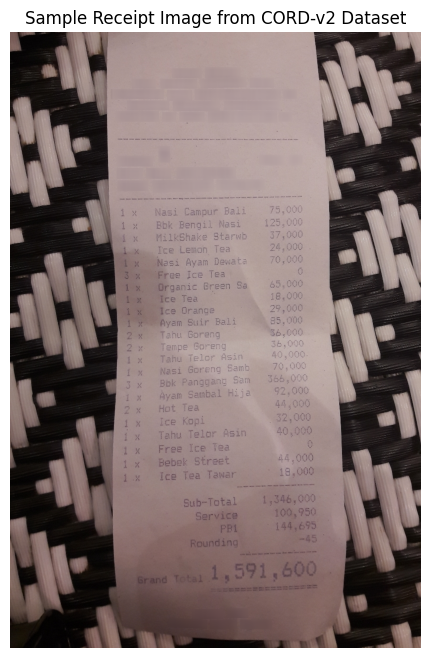

Image size: (864, 1296)
Image mode: RGB

Ground truth structure:
Keys in ground truth: dict_keys(['gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'])


In [41]:
# Display a sample image from the CORD-v2 dataset
sample = ds['train'][0]

# Get the image from the sample
image = sample['image']

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title('Sample Receipt Image from CORD-v2 Dataset')
plt.axis('off')
plt.show()

print(f"Image size: {image.size}")
print(f"Image mode: {image.mode}")
print(f"\nGround truth structure:")
ground_truth_dict = json.loads(sample['ground_truth'])
print(f"Keys in ground truth: {ground_truth_dict.keys()}")

## Separates the data into different folders

In [42]:
# The CORD-v2 dataset already comes with train/validation/test splits
# Let's verify the splits and their sizes

print("CORD-v2 Dataset Splits:")
print("=" * 50)

for split_name in ds.keys():
    split_size = len(ds[split_name])
    print(f"\n{split_name.upper()} split:")
    print(f"  - Number of samples: {split_size}")
    
    # Show a sample structure
    if split_size > 0:
        sample = ds[split_name][0]
        print(f"  - Sample keys: {list(sample.keys())}")

print("\n✓ Dataset is ready to use with pre-defined splits!")
print("\nNote: CORD-v2 contains:")
print("  - Receipt images")
print("  - OCR annotations")
print("  - Bounding box information")
print("  - Structured information extraction")

CORD-v2 Dataset Splits:

TRAIN split:
  - Number of samples: 800
  - Sample keys: ['image', 'ground_truth']

VALIDATION split:
  - Number of samples: 100
  - Sample keys: ['image', 'ground_truth']

TEST split:
  - Number of samples: 100
  - Sample keys: ['image', 'ground_truth']

✓ Dataset is ready to use with pre-defined splits!

Note: CORD-v2 contains:
  - Receipt images
  - OCR annotations
  - Bounding box information
  - Structured information extraction


# Model Definition with PyTorch Lightning
---

Define the model architecture and data module for receipt image processing.

In [43]:
class CORDDataset(Dataset):
    def __init__(
        self,
        hf_dataset,
        transform: Optional[Callable] = None,
    ):
        """
        hf_dataset: Hugging Face dataset split (train/validation/test)
        transform: torchvision transforms applied to images
        """
        self.hf_dataset = hf_dataset
        self.transform = transform

        print(f"[CORDDataset] Initialized with {len(self.hf_dataset)} samples.")

        # Default transform if none is given
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
            ])

    def __len__(self) -> int:
        return len(self.hf_dataset)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.hf_dataset[idx]
        
        # Get the image (PIL Image)
        image = sample['image']
        
        # Apply transforms
        image_tensor = self.transform(image)
        
        # Extract ground truth information
        ground_truth = sample['ground_truth']
        
        result = {
            "image": image_tensor,
            "ground_truth": ground_truth,
            "image_id": sample.get('id', idx),
        }
        return result

In [44]:
class CORDDataModule(L.LightningDataModule):
    def __init__(
        self,
        hf_dataset,
        batch_size: int = 4,
        num_workers: int = 0,
        train_transform: Optional[Callable] = None,
        test_transform: Optional[Callable] = None,
    ):
        super().__init__()
        self.hf_dataset = hf_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage: str = None):
        # Create datasets from HuggingFace splits
        self.train_dataset = CORDDataset(
            hf_dataset=self.hf_dataset['train'],
            transform=self.train_transform,
        )
        
        self.val_dataset = CORDDataset(
            hf_dataset=self.hf_dataset['validation'],
            transform=self.test_transform if self.test_transform else self.train_transform,
        )
        
        self.test_dataset = CORDDataset(
            hf_dataset=self.hf_dataset['test'],
            transform=self.test_transform if self.test_transform else self.train_transform,
        )

        print(f"[CORDDataModule] Train: {len(self.train_dataset)}, "
              f"Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [45]:
# Define train/test transforms
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Create CORD data module
cord_dm = CORDDataModule(
    hf_dataset=ds,
    batch_size=4,
    num_workers=0,
    train_transform=train_transform,
    test_transform=test_transform,
)

cord_dm.setup()

train_loader = cord_dm.train_dataloader()
val_loader = cord_dm.val_dataloader()

# Test loading a batch
batch = next(iter(train_loader))
print(f"Batch image shape: {batch['image'].shape}")
print(f"Batch keys: {batch.keys()}")
print(f"Number of samples in batch: {len(batch['image'])}")

[CORDDataset] Initialized with 800 samples.
[CORDDataset] Initialized with 100 samples.
[CORDDataset] Initialized with 100 samples.
[CORDDataModule] Train: 800, Val: 100, Test: 100
Batch image shape: torch.Size([4, 3, 512, 512])
Batch keys: dict_keys(['image', 'ground_truth', 'image_id'])
Number of samples in batch: 4
